**Confusion Matrix**

Saving holidays.csv to holidays.csv

📊 Results for Random Forest


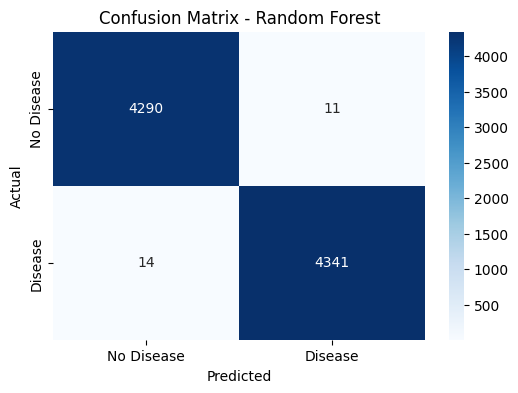

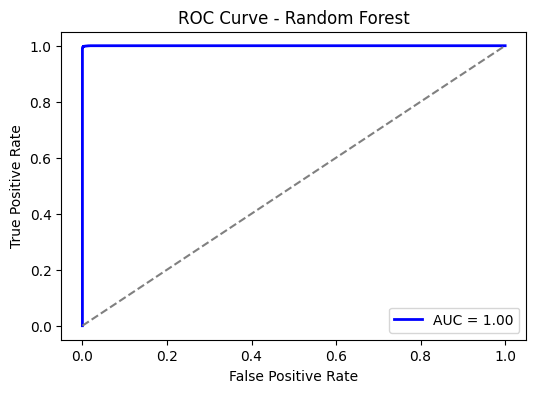

<ipython-input-1-69d1da80101e>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="Blues_r")


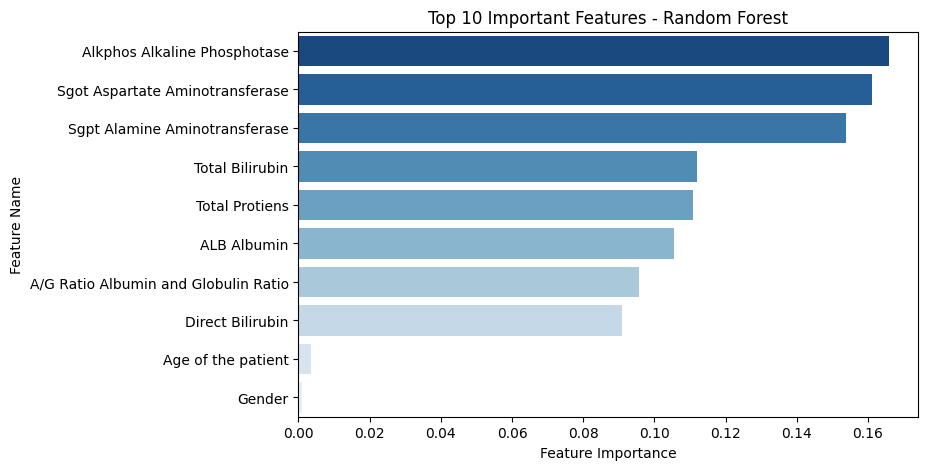


📊 Results for Gradient Boosting


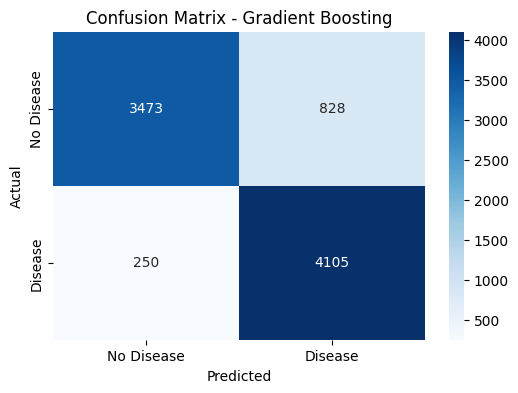

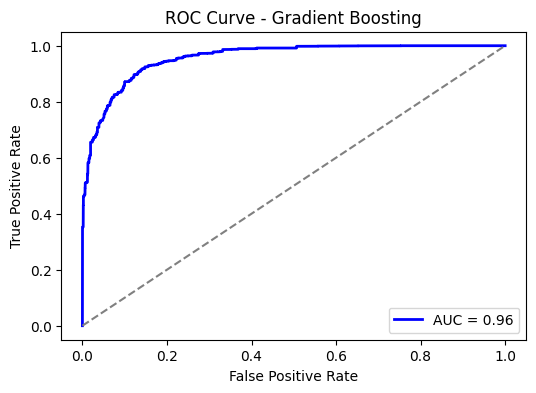

<ipython-input-1-69d1da80101e>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="Blues_r")


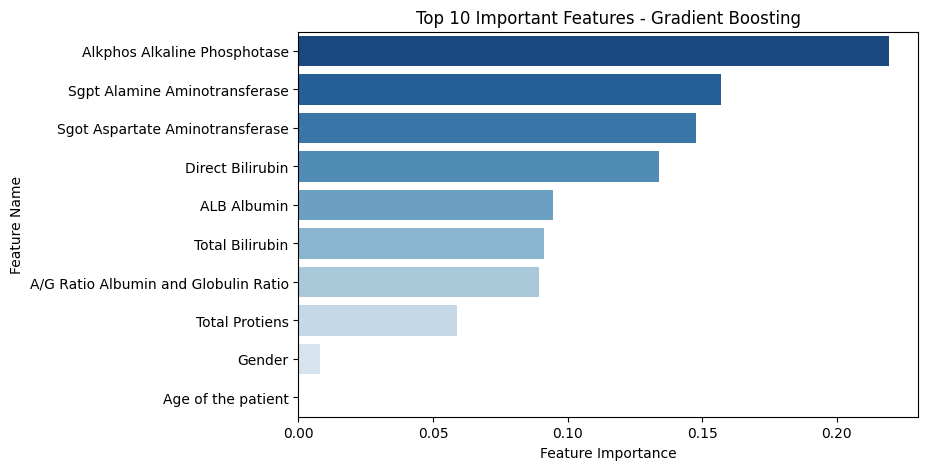


📊 Results for Extra Trees


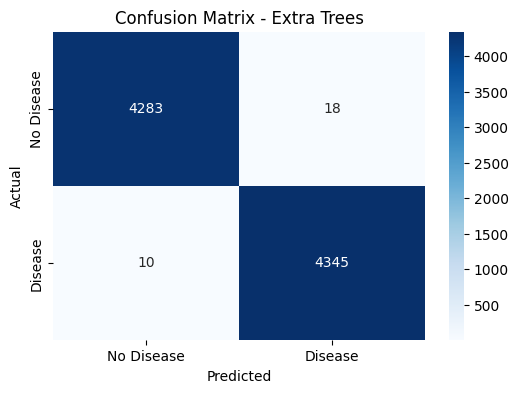

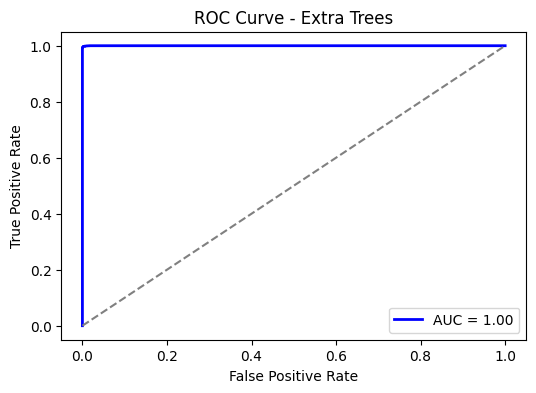

<ipython-input-1-69d1da80101e>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="Blues_r")


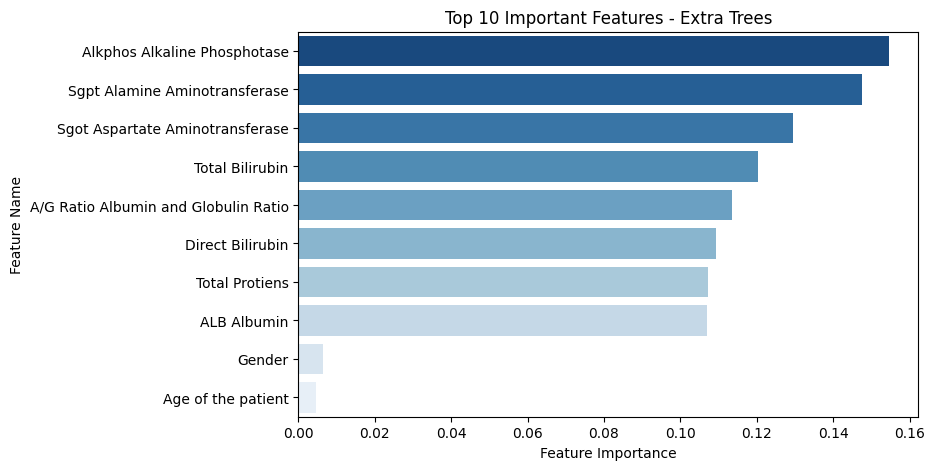

In [ ]:
# Install necessary libraries (if not installed)
!pip install matplotlib seaborn scikit-learn pandas numpy

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# Step 1: Upload the CSV file
uploaded = files.upload()  # Manually upload the CSV file

# Step 2: Load dataset (Change 'your_file.csv' to the correct file name)
file_name = list(uploaded.keys())[0]  # Automatically gets uploaded filename
df = pd.read_csv(file_name)

# Step 3: Data Preprocessing
# Assuming last column is the target variable (modify if needed)
X = df.iloc[:, :-1]  # Features (all except last column)
y = df.iloc[:, -1]   # Target (last column)

# Convert categorical variables if needed (modify as required)
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding for categorical data

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

y_preds = {}  # Store predictions
y_scores = {}  # Store probability scores

for name, model in models.items():
    model.fit(X_train, y_train)
    y_preds[name] = model.predict(X_test)
    y_scores[name] = model.predict_proba(X_test)[:, 1]  # Get probability scores

# Step 5: Visualization Functions

## 🔹 Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

## 🔹 ROC Curve
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

## 🔹 Feature Importance
def plot_feature_importance(model, X_train, model_name):
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="Blues_r")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.title(f"Top 10 Important Features - {model_name}")
    plt.show()

# Step 6: Generate Visualizations
for name, model in models.items():
    print(f"\n📊 Results for {name}")

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_preds[name], name)

    # ROC Curve
    plot_roc_curve(y_test, y_scores[name], name)

    # Feature Importance (only for tree-based models)
    if hasattr(model, "feature_importances_"):
        plot_feature_importance(model, X_train, name)


**Shap**

In [ ]:
# Install SHAP if not installed
!pip install shap

# Import Libraries
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from google.colab import files

# Step 1: Upload and Load Dataset
print("📂 Please upload your dataset...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Step 2: Data Preprocessing
df.dropna(inplace=True)  # Handle missing values

X = df.iloc[:, :-1]  # Features (assumes last column is the target)
y = df.iloc[:, -1]   # Target variable

# Convert categorical target into numerical (if necessary)
if y.dtype == 'O':
    y = pd.factorize(y)[0]

# One-hot encoding for categorical features (if needed)
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ensure feature order is the same for train & test
X_test = X_test[X_train.columns]

# Step 3: Train a Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: SHAP Explanation (Using TreeExplainer for Random Forest)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Check SHAP values shape
shap_values_array = np.array(shap_values)
num_classes = shap_values_array.shape[0] if len(shap_values_array.shape) == 3 else 1
print(f"SHAP values shape: {shap_values_array.shape}")

# 🔹 Handle Multi-Class SHAP Output Correctly
plt.figure(figsize=(10, 6))

if num_classes > 1:  # Multi-class case
    print(f"Detected multi-class classification ({num_classes} classes).")

    ### 🔹 OPTION 1: Select a Specific Class for SHAP (Fix Shape Issue)
    class_index = 1 if num_classes > 1 else 0  # Ensure class index is within range
    print(f"Visualizing SHAP values for class {class_index}.")

    shap_values_class = shap_values[class_index]  # Select specific class SHAP values
    shap_values_class = shap_values_class[:, :X_test.shape[1]]  # Ensure shape matches X_test

    shap.summary_plot(shap_values_class, X_test)

    ### 🔹 OPTION 2: Compute Absolute Mean SHAP Values Across All Classes
    shap_values_mean = np.mean(np.abs(shap_values_array), axis=0)  # Mean across all classes
    shap_values_mean = shap_values_mean[:, :X_test.shape[1]]  # Ensure shape matches X_test

    print("Visualizing SHAP values averaged across all classes.")
    shap.summary_plot(shap_values_mean, X_test)

else:  # Binary classification or regression
    print("Detected binary classification or regression.")
    shap.summary_plot(shap_values, X_test)

# 🔹 SHAP Feature Importance Bar Chart
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values_mean if num_classes > 1 else shap_values)


📂 Please upload your dataset...


Saving holidays.csv to holidays (7).csv
SHAP values shape: (8656, 10, 2)
Detected multi-class classification (8656 classes).
Visualizing SHAP values for class 1.


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x600 with 0 Axes>

**Lime**

In [ ]:
!pip install lime
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from google.colab import files

# Step 1: Upload and Load Dataset
uploaded = files.upload()  # Upload CSV manually
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Step 2: Data Preprocessing
X = df.iloc[:, :-1]  # Features (assumes last column is the target)
y = df.iloc[:, -1]   # Target variable

# One-hot encoding for categorical features (if needed)
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: LIME Explanation
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Disease', 'Disease'],
    mode='classification'
)

# Explain a single instance (change index as needed)
i = 5  # Select an instance from test set
exp = explainer.explain_instance(X_test.iloc[i].values, model.predict_proba)

# 🔹 LIME Explanation Plot
exp.show_in_notebook()  # Use in Jupyter or Colab

# 🔹 Save explanation as an image
exp.save_to_file('lime_explanation.html')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e384222ad8bbe2cca00d6fcff9d15a1f8a5aeeb667e705d35ed99429f3dc560c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Saving holidays.csv to holidays (2).csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


**Hyperparameter Tuning**

In [ ]:
# Install necessary libraries
!pip install xgboost lightgbm shap optuna tensorflow keras

# Import Libraries
import numpy as np
import pandas as pd
import shap
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Step 1: Upload and Load Dataset
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Step 2: Data Preprocessing
X = df.iloc[:, :-1]  # Features (assumes last column is the target)
y = df.iloc[:, -1]   # Target variable

# One-hot encoding for categorical features (if needed)
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Traditional ML Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gaussian Naïve Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Store results in a DataFrame
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Collect performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    results.append({"Model": name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1})

# Convert results to DataFrame and display as table
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Table:")
print(results_df)

# Step 4: Hyperparameter Tuning - GridSearchCV (Random Forest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"\n🔍 Best RF Parameters: {grid_search.best_params_}")

# Step 5: Hyperparameter Tuning - Bayesian Optimization (XGBoost)
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # FIXED deprecated function
        "subsample": trial.suggest_float("subsample", 0.5, 1.0)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# ✅ FIXED: Corrected Attribute for Best Parameters
print(f"\n🔍 Best XGBoost Parameters: {study.best_params}")

# Step 6: Display Results as Table
print("\n📊 Final Model Performance Table:")
print(results_df)

# Optional: Save the results to a CSV file
results_df.to_csv("model_performance_results.csv", index=False)
print("\n✅ Model results saved as 'model_performance_results.csv'")


Saving holidays.csv to holidays (4).csv


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:15:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17284, number of negative: 17338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 34622, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499220 -> initscore=-0.003119
[LightGBM] [Info] Start training from score -0.003119

📊 Model Performance Table:
                  Model  Accuracy  Precision    Recall  F1-Score
0         Random Forest  0.997112   0.997112  0.997112  0.997112
1   K-Nearest Neighbors  0.977241   0.977398  0.977241  0.977238
2  Gaussian Naïve Bayes  0.663817   0.717340  0.663817  0.640813
3               XGBoost  0.997112   0.997114  0.997112  0.997112
4              LightGBM  0.993415   0.993418  0.993415  0.993415


[I 2025-02-27 16:18:58,859] A new study created in memory with name: no-name-f65b5866-c5f7-4cc1-920a-4b10e9097b45



🔍 Best RF Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:18:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-27 16:18:59,312] Trial 0 finished with value: 0.9865988909426987 and parameters: {'n_estimators': 55, 'max_depth': 12, 'learning_rate': 0.023991827699250446, 'subsample': 0.6003327059591609}. Best is trial 0 with value: 0.9865988909426987.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:18:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-27 16:18:59,567] Trial 1 finished with value: 0.8985674676524954 and parameters: {'n_estimators': 87, 'max_depth': 4, 'learning_rate': 0.07384260192865756, 'subsample': 0.5770837190933309}. Best is trial 0 with value: 0.9865988909426987.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [1


🔍 Best XGBoost Parameters: {'n_estimators': 110, 'max_depth': 20, 'learning_rate': 0.09115047593252841, 'subsample': 0.844149665096426}

📊 Final Model Performance Table:
                  Model  Accuracy  Precision    Recall  F1-Score
0         Random Forest  0.997112   0.997112  0.997112  0.997112
1   K-Nearest Neighbors  0.977241   0.977398  0.977241  0.977238
2  Gaussian Naïve Bayes  0.663817   0.717340  0.663817  0.640813
3               XGBoost  0.997112   0.997114  0.997112  0.997112
4              LightGBM  0.993415   0.993418  0.993415  0.993415

✅ Model results saved as 'model_performance_results.csv'


**Model Testing**

**80-20**

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from google.colab import files
import io

# Step 1: Upload Dataset
print("📂 Please upload your dataset...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding="ISO-8859-1")

# Define normal ranges (from medical references)
normal_ranges = {
    "Total Bilirubin": (0.1, 1.2),
    "Direct Bilirubin": (0.0, 0.3),
    "Alkaline Phosphatase": (44, 147),
    "SGPT": (7, 56),
    "SGOT": (10, 40),
    "Total Proteins": (6.0, 8.3),
    "ALB": (3.5, 5.0),
    "A/G Ratio": (1.1, 2.5)
}

# Step 2: Add Binary Features for Normal Ranges
for feature, (low, high) in normal_ranges.items():
    if feature in df.columns:
        df[f"{feature}_Abnormal"] = ((df[feature] < low) | (df[feature] > high)).astype(int)

# Step 3: Prepare Data
target_column = "Result"
X = df.drop(columns=[target_column])
y = df[target_column]

# Standardize Numeric Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Define Models
models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagged Decision Tree": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naïve Bayes": GaussianNB()
}

# Step 6: Train & Evaluate Models (With New Features)
results = []
for name, model in models.items():
    print(f"🔄 Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    auc = roc_auc_score(y_test, y_pred) * 100
    runtime = (time.time() - start_time) / 60
    results.append([name, acc, prec, recall, f1, auc, runtime])

# Convert Results to DataFrame
columns = ["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)", "AUC-ROC (%)", "Runtime (mins.)"]
results_df = pd.DataFrame(results, columns=columns)
print(results_df)
results_df.to_csv("Model_Comparison_With_Ranges.csv", index=False)
files.download("Model_Comparison_With_Ranges.csv")

# Step 7: Cross-Validation with New Features
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = []
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=kf, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"], n_jobs=-1)
    cross_val_results.append([name, np.mean(scores["test_accuracy"]) * 100, np.mean(scores["test_precision"]) * 100,
                              np.mean(scores["test_recall"]) * 100, np.mean(scores["test_f1"]) * 100, np.mean(scores["test_roc_auc"]) * 100])
cross_val_df = pd.DataFrame(cross_val_results, columns=["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)", "AUC-ROC (%)"])
print(cross_val_df)
cross_val_df.to_csv("Model_Cross_Validation_With_Ranges.csv", index=False)
files.download("Model_Cross_Validation_With_Ranges.csv")

# Step 8: Hybrid Model (Random Forest + XGBoost)
rf_model = models["Random Forest"]
rf_train_preds = rf_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
rf_test_preds = rf_model.predict_proba(X_test)[:, 1].reshape(-1, 1)
xgb_hybrid = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
xgb_hybrid.fit(rf_train_preds, y_train)
final_preds = xgb_hybrid.predict(rf_test_preds)
hybrid_acc = accuracy_score(y_test, final_preds) * 100
print(f"Hybrid Model Accuracy: {hybrid_acc:.2f}%")


📂 Please upload your dataset...


Saving holidays.csv to holidays.csv
🔄 Training Gradient Boosting...
🔄 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:21:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔄 Training LightGBM...
[LightGBM] [Info] Number of positive: 17311, number of negative: 17311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1436
[LightGBM] [Info] Number of data points in the train set: 34622, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔄 Training Random Forest...
🔄 Training Extra Trees...
🔄 Training Bagged Decision Tree...
🔄 Training Decision Tree...
🔄 Training Logistic Regression...
🔄 Training K-Nearest Neighbors...
🔄 Training Gaussian Naïve Bayes...
                  Model  Accuracy (%)  Precision (%)  Recall (%)  \
0     Gradient Boosting     87.500000      83.686177   93.160813   
1               XGBoost     99.664972      99.722415   99.607209   
2              LightGBM     99.353050      99.490269   99.214418   
3         Random Forest     99.838262      99.861304   99.815157   
4           Extra Trees     99.653420      99.653420   99.653420   
5  Bagged Decision Tree     99.526340      99.629544   99.422366   
6         Decision Tree     99.249076      99.260458   99.237523   
7   Logistic Regression     68.310998      64.635272   80.868762   
8   K-Nearest Neighbors     96.487985      95.706497   97.342884   
9  Gaussian Naïve Bayes     67.121072      61.570893   91.104436   

   F1-Score (%)  AUC-ROC (%)  R

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                  Model  Accuracy (%)  Precision (%)  Recall (%)  \
0     Gradient Boosting     87.413913      82.705778   94.630042   
1               XGBoost     99.681133      99.681162   99.681132   
2              LightGBM     99.459309      99.381758   99.537875   
3         Random Forest     99.766625      99.824236   99.708855   
4           Extra Trees     99.678819      99.667401   99.690373   
5  Bagged Decision Tree     99.584086      99.689751   99.477794   
6         Decision Tree     99.269843      99.319972   99.219010   
7   Logistic Regression     68.270267      64.416021   81.644270   
8   K-Nearest Neighbors     97.968953      97.238716   98.743017   
9  Gaussian Naïve Bayes     66.678227      61.237655   90.891424   

   F1-Score (%)  AUC-ROC (%)  
0     88.263642    95.726864  
1     99.681129    99.977187  
2     99.459744    99.959365  
3     99.766466    99.989954  
4     99.678868    99.988319  
5     99.583649    99.963301  
6     99.269453    99.269793  
7  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hybrid Model Accuracy: 99.63%


**70-30**

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from google.colab import files
import io

# Step 1: Upload Dataset
print("📂 Please upload your dataset...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding="ISO-8859-1")

# Define normal ranges (from medical references)
normal_ranges = {
    "Total Bilirubin": (0.1, 1.2),
    "Direct Bilirubin": (0.0, 0.3),
    "Alkaline Phosphatase": (44, 147),
    "SGPT": (7, 56),
    "SGOT": (10, 40),
    "Total Proteins": (6.0, 8.3),
    "ALB": (3.5, 5.0),
    "A/G Ratio": (1.1, 2.5)
}

# Step 2: Add Binary Features for Normal Ranges
for feature, (low, high) in normal_ranges.items():
    if feature in df.columns:
        df[f"{feature}_Abnormal"] = ((df[feature] < low) | (df[feature] > high)).astype(int)

# Step 3: Prepare Data
target_column = "Result"
X = df.drop(columns=[target_column])
y = df[target_column]

# Standardize Numeric Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split Data (70% Training, 30% Testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Step 5: Define Models
models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagged Decision Tree": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naïve Bayes": GaussianNB()
}

# Step 6: Train & Evaluate Models (With New Features)
results = []
for name, model in models.items():
    print(f"🔄 Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    auc = roc_auc_score(y_test, y_pred) * 100
    runtime = (time.time() - start_time) / 60
    results.append([name, acc, prec, recall, f1, auc, runtime])

# Convert Results to DataFrame
columns = ["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)", "AUC-ROC (%)", "Runtime (mins.)"]
results_df = pd.DataFrame(results, columns=columns)
print(results_df)
results_df.to_csv("Model_Comparison_70_30.csv", index=False)
files.download("Model_Comparison_70_30.csv")

# Step 7: Cross-Validation with New Features
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = []
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=kf, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"], n_jobs=-1)
    cross_val_results.append([name, np.mean(scores["test_accuracy"]) * 100, np.mean(scores["test_precision"]) * 100,
                              np.mean(scores["test_recall"]) * 100, np.mean(scores["test_f1"]) * 100, np.mean(scores["test_roc_auc"]) * 100])
cross_val_df = pd.DataFrame(cross_val_results, columns=["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)", "AUC-ROC (%)"])
print(cross_val_df)
cross_val_df.to_csv("Model_Cross_Validation_70_30.csv", index=False)
files.download("Model_Cross_Validation_70_30.csv")

# Step 8: Hybrid Model (Random Forest + XGBoost)
rf_model = models["Random Forest"]
rf_train_preds = rf_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
rf_test_preds = rf_model.predict_proba(X_test)[:, 1].reshape(-1, 1)
xgb_hybrid = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
xgb_hybrid.fit(rf_train_preds, y_train)
final_preds = xgb_hybrid.predict(rf_test_preds)
hybrid_acc = accuracy_score(y_test, final_preds) * 100
print(f"Hybrid Model Accuracy: {hybrid_acc:.2f}%")



📂 Please upload your dataset...


Saving holidays.csv to holidays (1).csv
🔄 Training Gradient Boosting...
🔄 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:26:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔄 Training LightGBM...
[LightGBM] [Info] Number of positive: 15147, number of negative: 15147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 30294, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔄 Training Random Forest...
🔄 Training Extra Trees...
🔄 Training Bagged Decision Tree...
🔄 Training Decision Tree...
🔄 Training Logistic Regression...
🔄 Training K-Nearest Neighbors...
🔄 Training Gaussian Naïve Bayes...
                  Model  Accuracy (%)  Precision (%)  Recall (%)  \
0     Gradient Boosting     87.939002      83.256819   94.978435   
1               XGBoost     99.661121      99.615266   99.707332   
2              LightGBM     99.430068      99.430068   99.430068   
3         Random Forest     99.776648      99.753657   99.799754   
4           Extra Trees     99.661121      99.615266   99.707332   
5  Bagged Decision Tree     99.507086      99.660074   99.353050   
6         Decision Tree     99.075786      99.015385   99.137400   
7   Logistic Regression     68.592113      64.809816   81.361676   
8   K-Nearest Neighbors     96.048983      94.975177   97.242760   
9  Gaussian Naïve Bayes     66.897720      61.462905   90.603820   

   F1-Score (%)  AUC-ROC (%)  R

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                  Model  Accuracy (%)  Precision (%)  Recall (%)  \
0     Gradient Boosting     87.413913      82.705778   94.630042   
1               XGBoost     99.681133      99.681162   99.681132   
2              LightGBM     99.459309      99.381758   99.537875   
3         Random Forest     99.773558      99.801227   99.745828   
4           Extra Trees     99.699615      99.690506   99.708859   
5  Bagged Decision Tree     99.563292      99.689689   99.436204   
6         Decision Tree     99.237493      99.292241   99.182042   
7   Logistic Regression     68.270267      64.416021   81.644270   
8   K-Nearest Neighbors     97.968953      97.238716   98.743017   
9  Gaussian Naïve Bayes     66.678227      61.237655   90.891424   

   F1-Score (%)  AUC-ROC (%)  
0     88.263642    95.726172  
1     99.681129    99.977187  
2     99.459744    99.959365  
3     99.773469    99.991984  
4     99.699662    99.988124  
5     99.562746    99.967861  
6     99.237067    99.237444  
7  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hybrid Model Accuracy: 99.66%


**No Range 70-30**

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from google.colab import files
import io

# Step 1: Upload Dataset
print("\U0001F4C2 Please upload your dataset...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding="ISO-8859-1")

# Step 2: Prepare Data
target_column = "Result"
X = df.drop(columns=[target_column])
y = df[target_column]

# Standardize Numeric Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Define Models
models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagged Decision Tree": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naïve Bayes": GaussianNB()
}

# Step 5: Train & Evaluate Models
results = []
for name, model in models.items():
    print(f"\U0001F504 Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    auc = roc_auc_score(y_test, y_pred) * 100
    runtime = (time.time() - start_time) / 60
    results.append([name, acc, prec, recall, f1, auc, runtime])

# Convert Results to DataFrame
columns = ["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)", "AUC-ROC (%)", "Runtime (mins.)"]
results_df = pd.DataFrame(results, columns=columns)
print(results_df)
results_df.to_csv("Model_Comparison.csv", index=False)
files.download("Model_Comparison.csv")

# Step 6: Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = []
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=kf, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"], n_jobs=-1)
    cross_val_results.append([name, np.mean(scores["test_accuracy"]) * 100, np.mean(scores["test_precision"]) * 100,
                              np.mean(scores["test_recall"]) * 100, np.mean(scores["test_f1"]) * 100, np.mean(scores["test_roc_auc"]) * 100])
cross_val_df = pd.DataFrame(cross_val_results, columns=["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)", "AUC-ROC (%)"])
print(cross_val_df)
cross_val_df.to_csv("Model_Cross_Validation.csv", index=False)
files.download("Model_Cross_Validation.csv")

# Step 7: Hybrid Model (Random Forest + XGBoost)
rf_model = models["Random Forest"]
rf_train_preds = rf_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
rf_test_preds = rf_model.predict_proba(X_test)[:, 1].reshape(-1, 1)
xgb_hybrid = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
xgb_hybrid.fit(rf_train_preds, y_train)
final_preds = xgb_hybrid.predict(rf_test_preds)
hybrid_acc = accuracy_score(y_test, final_preds) * 100
print(f"Hybrid Model Accuracy: {hybrid_acc:.2f}%")


📂 Please upload your dataset...


Saving Processed_Dataset_Winsorized (1).csv to Processed_Dataset_Winsorized (1).csv
🔄 Training Gradient Boosting...
🔄 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:11:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔄 Training LightGBM...
[LightGBM] [Info] Number of positive: 17311, number of negative: 17311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 34622, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔄 Training Random Forest...
🔄 Training Extra Trees...
🔄 Training Bagged Decision Tree...
🔄 Training Decision Tree...
🔄 Training Logistic Regression...
🔄 Training K-Nearest Neighbors...
🔄 Training Gaussian Naïve Bayes...
                  Model  Accuracy (%)  Precision (%)  Recall (%)  \
0     Gradient Boosting     88.216266      83.604226   95.078558   
1               XGBoost     99.653420      99.768411   99.537893   
2              LightGBM     99.445471      99.559981   99.329945   
3         Random Forest     99.815157      99.838188   99.792052   
4           Extra Trees     99.792052      99.792052   99.792052   
5  Bagged Decision Tree     99.641867      99.768358   99.514787   
6         Decision Tree     99.202865      99.259773   99.145102   
7   Logistic Regression     68.576710      65.437788   78.743068   
8   K-Nearest Neighbors     98.105360      97.884085   98.336414   
9  Gaussian Naïve Bayes     68.230129      64.054150   83.086876   

   F1-Score (%)  AUC-ROC (%)  R

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                  Model  Accuracy (%)  Precision (%)  Recall (%)  \
0     Gradient Boosting     88.377453      84.001688   94.819541   
1               XGBoost     99.690373      99.662886   99.718099   
2              LightGBM     99.454690      99.404586   99.505524   
3         Random Forest     99.768937      99.782790   99.755075   
4           Extra Trees     99.789731      99.778231   99.801283   
5  Bagged Decision Tree     99.618745      99.703781   99.533247   
6         Decision Tree     99.297570      99.334089   99.260603   
7   Logistic Regression     68.184761      64.961503   78.959270   
8   K-Nearest Neighbors     97.698605      96.965942   98.479604   
9  Gaussian Naïve Bayes     68.214805      63.897949   83.746931   

   F1-Score (%)  AUC-ROC (%)  
0     89.079880    95.929607  
1     99.690448    99.977763  
2     99.454992    99.955320  
3     99.768891    99.990174  
4     99.789745    99.990206  
5     99.618415    99.982130  
6     99.297320    99.297526  
7  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hybrid Model Accuracy: 99.70%


**No range 80-20**

In [ ]:
import pandas as pd
import numpy as np
import time
import joblib  # For saving and loading models
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from google.colab import files
import io

# Step 1: Upload Dataset
print("📂 Please upload your dataset...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding="ISO-8859-1")

# Define normal ranges (from medical references)
normal_ranges = {
    "Total Bilirubin": (0.1, 1.2),
    "Direct Bilirubin": (0.0, 0.3),
    "Alkaline Phosphatase": (44, 147),
    "SGPT": (7, 56),
    "SGOT": (10, 40),
    "Total Proteins": (6.0, 8.3),
    "ALB": (3.5, 5.0),
    "A/G Ratio": (1.1, 2.5)
}

# Step 2: Add Binary Features for Normal Ranges
for feature, (low, high) in normal_ranges.items():
    if feature in df.columns:
        df[f"{feature}_Abnormal"] = ((df[feature] < low) | (df[feature] > high)).astype(int)

# Step 3: Prepare Data
target_column = "Result"
X = df.drop(columns=[target_column])
y = df[target_column]

# Standardize Numeric Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split Data (70% Training, 30% Testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Step 5: Define Models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "Random Forest": RandomForestClassifier(),
    "LightGBM": LGBMClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Bagged Decision Tree": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naïve Bayes": GaussianNB()
}

# Step 6: Train & Evaluate Models
best_model = None
best_accuracy = 0
for name, model in models.items():
    print(f"🔄 Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model  # Save the best performing model

# Save the Best Model
joblib.dump(best_model, "Best_Liver_Disease_Model.pkl")
files.download("Best_Liver_Disease_Model.pkl")
print(f"✅ Best Model ({type(best_model).__name__}) saved with accuracy: {best_accuracy:.2f}%")

# Step 7: Function to Test New Patient Data
def predict_liver_disease():
    print("\n📌 Enter patient details below:")
    patient_data = []

    for feature in X.columns:
        value = float(input(f"Enter {feature}: "))
        patient_data.append(value)

    # Convert input data to array and standardize
    patient_array = np.array(patient_data).reshape(1, -1)
    patient_scaled = scaler.transform(patient_array)

    # Load the best model
    best_model = joblib.load("Best_Liver_Disease_Model.pkl")

    # Make Prediction
    prediction = best_model.predict(patient_scaled)[0]
    result = "Liver Disease Detected (1)" if prediction == 1 else "Healthy (0)"

    print(f"\n🔍 **Prediction:** {result}")

# Step 8: Run User Input Function
predict_liver_disease()
